In [10]:
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
import pandas as pd

df1 = pd.read_csv("/content/drive/MyDrive/pm102022.csv")
df2 = pd.read_csv("/content/drive/MyDrive/pm102023.csv")

df_union = pd.concat([df1, df2], ignore_index=True)

print(df_union.head())


         Date Source   Site ID  POC  Daily Mean PM10 Concentration     Units  \
0  01/01/2022    AQS  10730023    4                             14  ug/m3 SC   
1  01/02/2022    AQS  10730023    4                              7  ug/m3 SC   
2  01/05/2022    AQS  10730023    4                             21  ug/m3 SC   
3  01/06/2022    AQS  10730023    4                             21  ug/m3 SC   
4  01/07/2022    AQS  10730023    4                             13  ug/m3 SC   

   Daily AQI Value   Local Site Name  Daily Obs Count  Percent Complete  ...  \
0               13  North Birmingham                1             100.0  ...   
1                6  North Birmingham                1             100.0  ...   
2               19  North Birmingham                1             100.0  ...   
3               19  North Birmingham                1             100.0  ...   
4               12  North Birmingham                1             100.0  ...   

   AQS Parameter Description Method Co

In [12]:
import pandas as pd

# === 1. Unir datasets ===
df1 = pd.read_csv("/content/drive/MyDrive/pm102022.csv")
df2 = pd.read_csv("/content/drive/MyDrive/pm102023.csv")
df_union = pd.concat([df1, df2], ignore_index=True)

# === 2. Parsear la fecha (mm/dd/yyyy en tu dataset) ===
df_union["Date"] = pd.to_datetime(df_union["Date"], format="%m/%d/%Y", errors="coerce")
df_union["Year"] = df_union["Date"].dt.year
df_union["Month"] = df_union["Date"].dt.month

# === 3. Agrupar por Año y Mes para obtener promedio mensual ===
df_grouped = df_union.groupby(["Year", "Month"], as_index=False)["Daily Mean PM10 Concentration"].mean()

# === 4. Crear columnas de años (one-hot) ===
for year in df_grouped["Year"].unique():
    df_grouped[f"Year_{year}"] = (df_grouped["Year"] == year).astype(int)

# === 5. Crear columnas de meses (one-hot) ===
for m in range(1, 13):
    df_grouped[f"Month_{str(m).zfill(2)}"] = (df_grouped["Month"] == m).astype(int)

# === 6. Orden final de columnas ===
year_cols = sorted([c for c in df_grouped.columns if c.startswith("Year_")])
month_cols = [f"Month_{str(i).zfill(2)}" for i in range(1, 13)]
df_final = df_grouped[["Daily Mean PM10 Concentration"] + year_cols + month_cols]

print(df_final)


    Daily Mean PM10 Concentration  Year_2022  Year_2023  Month_01  Month_02  \
0                       14.477011          1          0         1         0   
1                       17.885870          1          0         0         1   
2                       20.206422          1          0         0         0   
3                       20.258772          1          0         0         0   
4                       20.639485          1          0         0         0   
5                       22.590476          1          0         0         0   
6                       17.187793          1          0         0         0   
7                       16.328829          1          0         0         0   
8                       19.132743          1          0         0         0   
9                       20.543478          1          0         0         0   
10                      15.481982          1          0         0         0   
11                      13.310924          1        


Archivo cargado: /content/drive/MyDrive/pm102022.csv
Columnas detectadas: ['Date', 'Source', 'Site ID', 'POC', 'Daily Mean PM10 Concentration', 'Units', 'Daily AQI Value', 'Local Site Name', 'Daily Obs Count', 'Percent Complete', 'AQS Parameter Code', 'AQS Parameter Description', 'Method Code', 'CBSA Code', 'CBSA Name', 'State FIPS Code', 'State', 'County FIPS Code', 'County', 'Site Latitude', 'Site Longitude']

Archivo cargado: /content/drive/MyDrive/pm102023.csv
Columnas detectadas: ['Date', 'Source', 'Site ID', 'POC', 'Daily Mean PM10 Concentration', 'Units', 'Daily AQI Value', 'Local Site Name', 'Daily Obs Count', 'Percent Complete', 'AQS Parameter Code', 'AQS Parameter Description', 'Method Code', 'CBSA Code', 'CBSA Name', 'State FIPS Code', 'State', 'County FIPS Code', 'County', 'Site Latitude', 'Site Longitude']

Archivo cargado: /content/drive/MyDrive/pm102025.csv
Columnas detectadas: ['Date', 'Source', 'Site ID', 'POC', 'Daily Mean PM10 Concentration', 'Units', 'Daily AQI Val

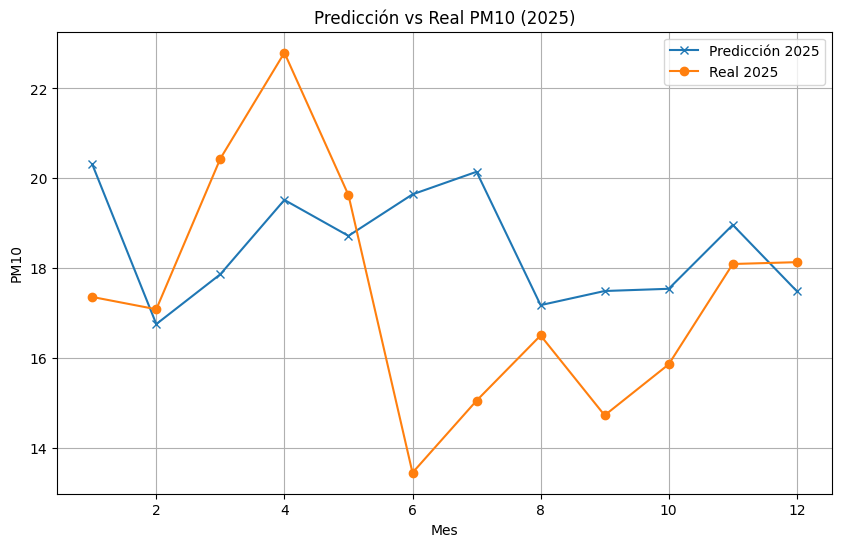

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

# ===== CONFIGURA LAS RUTAS AQUÍ =====
FILE_2022 = "/content/drive/MyDrive/pm102022.csv"
FILE_2023 = "/content/drive/MyDrive/pm102023.csv"
FILE_2025 = "/content/drive/MyDrive/pm102025.csv"
# ===================================

def read_df(path):
    df = pd.read_csv(path)
    print(f"\nArchivo cargado: {path}")
    print("Columnas detectadas:", df.columns.tolist())
    # detectar columna de fecha
    date_cols = [c for c in df.columns if 'date' in c.lower() or 'fecha' in c.lower()]
    date_col = date_cols[0] if date_cols else df.columns[0]  # fallback
    df[date_col] = pd.to_datetime(df[date_col], errors='coerce', dayfirst=True)
    # detectar PM10
    pm_col = None
    for c in df.columns:
        if "pm10" in c.lower():
            pm_col = c
            break
    if pm_col is None:
        raise ValueError(f"No se detectó columna PM10 en {path}.")
    df = df[[date_col, pm_col]].rename(columns={date_col: "Date", pm_col: "PM10"})
    df = df.dropna(subset=["Date", "PM10"])
    df["Year"] = df["Date"].dt.year
    df["Month"] = df["Date"].dt.month
    return df

# === 1. Cargar datos ===
df22 = read_df(FILE_2022)
df23 = read_df(FILE_2023)
df25 = read_df(FILE_2025)

# === 2. Entrenamiento con 2022+2023 ===
train = pd.concat([df22, df23], ignore_index=True)
train_monthly = train.groupby(["Year", "Month"], as_index=False)["PM10"].mean()

# One-hot para año y mes
for y in sorted(train_monthly["Year"].unique().tolist() + [2025]):
    train_monthly[f"Year_{y}"] = (train_monthly["Year"] == y).astype(int)
for m in range(1, 13):
    train_monthly[f"Month_{m:02d}"] = (train_monthly["Month"] == m).astype(int)

features = [c for c in train_monthly.columns if c.startswith("Year_") or c.startswith("Month_")]
X_train = train_monthly[features]
y_train = train_monthly["PM10"]

model = LinearRegression()
model.fit(X_train, y_train)

# === 3. Predicciones para 2025 ===
df_pred = pd.DataFrame({"Year": [2025]*12, "Month": range(1,13)})
for y in sorted(train_monthly["Year"].unique().tolist() + [2025]):
    df_pred[f"Year_{y}"] = (df_pred["Year"] == y).astype(int)
for m in range(1, 13):
    df_pred[f"Month_{m:02d}"] = (df_pred["Month"] == m).astype(int)

X_test = df_pred[features]
df_pred["Predicted_PM10"] = model.predict(X_test)

# === 4. Datos reales 2025 ===
df25_monthly = df25.groupby(["Year", "Month"], as_index=False)["PM10"].mean()
df_pred = df_pred.merge(df25_monthly, on=["Year", "Month"], how="left", suffixes=("", "_Real"))

# === 5. Calcular MAE y RMSE ===
mae = mean_absolute_error(df_pred["PM10"], df_pred["Predicted_PM10"])
mse = mean_squared_error(df_pred["PM10"], df_pred["Predicted_PM10"])  # sin squared=False
rmse = np.sqrt(mse)  # calculamos la raíz manualmente

print(f"\n📊 Métricas de desempeño:")
print(f"MAE  = {mae:.2f} µg/m³")
print(f"RMSE = {rmse:.2f} µg/m³")

# Error absoluto por mes
df_pred["Error_Abs"] = (df_pred["Predicted_PM10"] - df_pred["PM10"]).abs()
print("\nErrores absolutos por mes:")
print(df_pred[["Month", "Predicted_PM10", "PM10", "Error_Abs"]])

# === 6. Graficar ===
plt.figure(figsize=(10,6))
plt.plot(df_pred["Month"], df_pred["Predicted_PM10"], marker='x', label="Predicción 2025")
plt.plot(df_pred["Month"], df_pred["PM10"], marker='o', label="Real 2025")
plt.xlabel("Mes")
plt.ylabel("PM10")
plt.title("Predicción vs Real PM10 (2025)")
plt.legend()
plt.grid(True)
plt.show()
